In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# base_model = ResNet50(weights='imagenet', include_top=False)


In [22]:
model = Sequential([
    
    Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(256,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(512,activation='relu'),
    # Dense(117,activation='softmax')
    Dense(27,activation='softmax')
])

# Should add metric=[...]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = r'..\Data\labledBrazil\train'
validation_data_dir = r'..\Data\labledBrazil\val'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [25]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    # shuffle=True
    )

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical')


Found 16661 images belonging to 27 classes.
Found 2063 images belonging to 27 classes.


In [26]:
import numpy as np

class_counts = np.bincount(train_generator.classes) ** 0.01

# class_probabilities = class_counts
class_probabilities = class_counts / np.bincount(train_generator.classes)
class_probabilities = np.where(np.isinf(class_probabilities) | np.isnan(class_probabilities), 0, class_probabilities)
# class_probabilities[44] = 0
class_probabilities = class_probabilities / np.sum(class_probabilities)
class_weights = {i: weight for i, weight in enumerate(class_probabilities)}

class_indices = train_generator.class_indices

class_probabilities_dict = {class_name: class_probabilities[idx] for class_name, idx in class_indices.items()}

sorted_class_probabilities = sorted(class_probabilities_dict.items(), key=lambda item: item[1], reverse=False)

for class_name, probability in sorted_class_probabilities:
    print(f'{class_name}: {probability}')


Paraná: 0.019481721441815016
Minas Gerais: 0.020158747080248837
Pernambuco: 0.020280285162726182
Santa Catarina: 0.02040330519003744
Bahia: 0.020428089421040362
Mato Grosso: 0.020477839876088984
Rio Grande do Sul: 0.020603288115689893
Rio de Janeiro: 0.02062856336836669
Ceará: 0.020653901024816443
São Paulo: 0.02080725050357148
Goiás: 0.02093680101673449
Pará: 0.02106798315893939
Maranhão: 0.02147163408612648
Mato Grosso do Sul: 0.021919690854752205
Tocantins: 0.02218008122049552
Piauí: 0.02341682539426227
Rio Grande do Norte: 0.025362665613344104
Espírito Santo: 0.02615337824501036
Paraíba: 0.02910433467651427
Roraima: 0.042375986536543425
Sergipe: 0.047167886738209125
Acre: 0.05988725622012059
Rondônia: 0.060985088218333074
Amazonas: 0.06714278625161071
Alagoas: 0.06852746296727748
Distrito Federal: 0.09641161342563255
Amapá: 0.14196553419169264


In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    # steps_per_epoch=2000,
    validation_data=validation_generator,
    # validation_steps=200,
    batch_size=64,
    epochs=10,
    # class_weight = class_weights,
    # verbose=1
    callbacks=[early_stopping]
)

Epoch 1/10
261/261 [==============================] - 382s 1s/step - loss: 3.1851 - categorical_accuracy: 0.0609 - val_loss: 3.0755 - val_categorical_accuracy: 0.0834
Epoch 2/10
261/261 [==============================] - 137s 521ms/step - loss: 3.0481 - categorical_accuracy: 0.1006 - val_loss: 2.9917 - val_categorical_accuracy: 0.1260
Epoch 3/10
261/261 [==============================] - 145s 557ms/step - loss: 2.9279 - categorical_accuracy: 0.1332 - val_loss: 2.9151 - val_categorical_accuracy: 0.1396
Epoch 4/10
261/261 [==============================] - 165s 631ms/step - loss: 2.7867 - categorical_accuracy: 0.1672 - val_loss: 2.7932 - val_categorical_accuracy: 0.1590
Epoch 5/10
261/261 [==============================] - 164s 630ms/step - loss: 2.6373 - categorical_accuracy: 0.2013 - val_loss: 2.7653 - val_categorical_accuracy: 0.1537
Epoch 6/10
261/261 [==============================] - 192s 731ms/step - loss: 2.4632 - categorical_accuracy: 0.2427 - val_loss: 2.7996 - val_categorical_

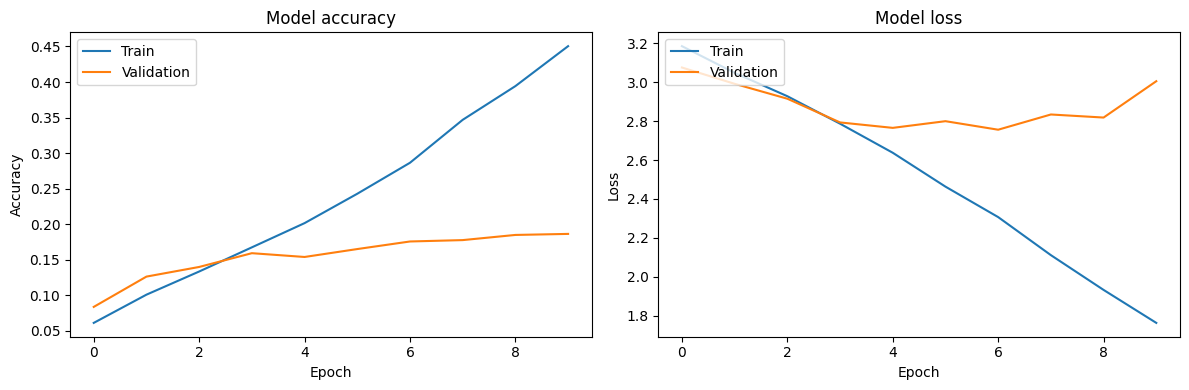

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [29]:
model.save('my_model.h5')


c:\Users\21thebes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

data_dir = r'..\Data\labledBrazil\test'
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

class_names = train_generator.class_indices.keys()
print(len(class_names))

Found 2040 images belonging to 27 classes.
27


64/64 [==============================] - 36s 563ms/step
Classification Report: 
                     precision    recall  f1-score   support

               Acre       0.00      0.00      0.00        20
            Alagoas       0.21      0.05      0.08        60
              Amapá       0.00      0.00      0.00        10
           Amazonas       0.06      0.07      0.06        30
              Bahia       0.12      0.05      0.07       100
              Ceará       0.22      0.22      0.22       114
   Distrito Federal       0.12      0.03      0.05        30
     Espírito Santo       0.15      0.17      0.16        90
              Goiás       0.19      0.03      0.05       101
           Maranhão       0.16      0.29      0.21        95
        Mato Grosso       0.30      0.17      0.22        89
 Mato Grosso do Sul       0.25      0.26      0.25       113
       Minas Gerais       0.14      0.07      0.10        94
             Paraná       0.14      0.30      0.19        77
    

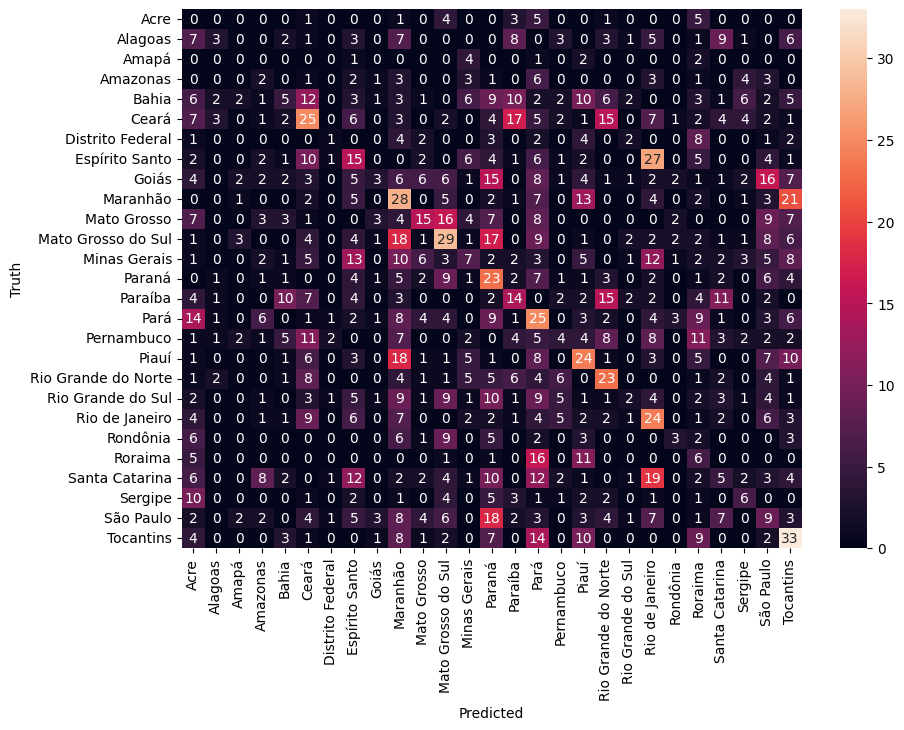

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes

# Predict the values from the validation dataset
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# classification report
print('Classification Report: ')
print(classification_report(y_true, y_pred_classes, target_names=class_names))


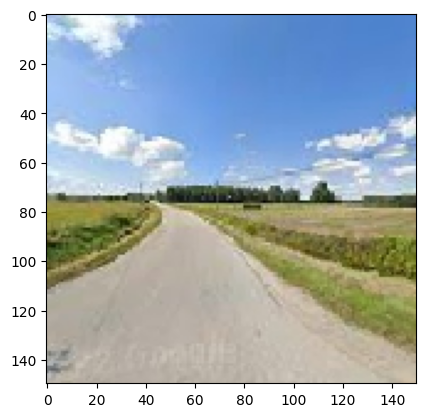

1/1 [==============================] - 0s 219ms/step
Country: ['Santa Catarina'], Probability: 0.26632827520370483
Country: ['Ceará'], Probability: 0.20019790530204773
Country: ['Rio de Janeiro'], Probability: 0.13761483132839203
Country: ['Rio Grande do Norte'], Probability: 0.09343528747558594
Country: ['Bahia'], Probability: 0.05050118640065193
Country: ['Pernambuco'], Probability: 0.041846826672554016
Country: ['Paraíba'], Probability: 0.03961991146206856
Country: ['Alagoas'], Probability: 0.03702876344323158
Country: ['Espírito Santo'], Probability: 0.030460387468338013
Country: ['Sergipe'], Probability: 0.020964408293366432
Country: ['Minas Gerais'], Probability: 0.018657900393009186
Country: ['São Paulo'], Probability: 0.01611575484275818
Country: ['Rio Grande do Sul'], Probability: 0.012912197969853878
Country: ['Paraná'], Probability: 0.01242736540734768
Country: ['Goiás'], Probability: 0.011226465925574303
Country: ['Distrito Federal'], Probability: 0.0024212198331952095
Coun

In [32]:
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load image
img_path = r'..\Data\labledCountries\test\Poland\_t3q0ct2UHEnJ0t3jR2SkQNum0.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Display the image
plt.imshow(img)
plt.show()

# Preprocess image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

# Make prediction
predictions = model.predict(x)

# Print predictions in sorted order
label_encoder = LabelEncoder()
label_encoder.fit(list(class_names))

for i in np.argsort(predictions[0])[::-1]:
    print(f'Country: {label_encoder.inverse_transform([i])}, Probability: {predictions[0][i]}')


In [33]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



2.15.0
No GPU found
